In [124]:
import yfinance as yf
import pandas as pd
import numpy as np
pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import xgboost as xgb

In [116]:
msft        = yf.Ticker('MSFT')
df          = msft.history(period = 'max')
df['Close'] = np.log(df['Close'])

In [117]:
df['FwdRet1']   = df['Close'].shift(-1)   - df['Close']
df['FwdRet5']   = df['Close'].shift(-5)   - df['Close']
df['FwdRet30']  = df['Close'].shift(-30)  - df['Close']
df['FwdRet126'] = df['Close'].shift(-126) - df['Close']
df['FwdRet252'] = df['Close'].shift(-252) - df['Close']

In [118]:
avgs = [5, 10, 30, 126, 252]
for avg in avgs:
    df[f'sma-{avg}-rat'] = df['Close'].rolling(avg).mean() / df['Close']
    df[f'vol-{avg}-chg'] = df['Volume'].pct_change(avg)

In [119]:
df['Volatility'] = ((df['High'] - df['Low']) / df['Close']).pct_change()

In [120]:
fwd_rets = [1, 5, 30, 126, 252]

for ret in fwd_rets:
    for i in range(1, 3):
        df[f'FwdRet{ret}-shft-{i}'] = df[f'FwdRet{ret}'].shift(i)

In [121]:
thirty_cols = ['FwdRet30', 'sma-5-rat', 'Volatility',
       'vol-5-chg', 'sma-10-rat', 'vol-10-chg', 'sma-30-rat', 'vol-30-chg',
       'sma-126-rat', 'vol-126-chg', 'sma-252-rat', 'vol-252-chg', 'FwdRet1-shft-1', 'FwdRet1-shft-2', 'FwdRet5-shft-1',
       'FwdRet5-shft-2', 'FwdRet30-shft-1', 'FwdRet30-shft-2',
       'FwdRet126-shft-1', 'FwdRet126-shft-2', 'FwdRet252-shft-1',
       'FwdRet252-shft-2']

df30 = df[thirty_cols]

In [122]:
df30 = df30.dropna()

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df30.drop('FwdRet30', axis = 1), df30['FwdRet30'], test_size = .20, shuffle = False)

In [131]:
mod  = xgb.XGBRegressor(colsample_bytree = 0.5)
mod2 = xgb.XGBClassifier(colsample_bytree = 0.5)

In [132]:
df['FwdRet30'].plot(kind = 'hist')

In [133]:
mod.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [134]:
# training score
mod.score(X_train, y_train)

0.992756692117484

In [136]:
# test score
mod.score(X_test, y_test)

0.9162908838869539

In [147]:
# a naive base line -- predicting yesterday's value
1 - (np.mean((y_test - y_test.shift())**2) / np.mean((y_test - y_test.mean())**2))

0.8637714034844298

In [139]:
# plot the differences
fig = go.Figure()
fig.add_trace(go.Scatter(x = X_test.index, y=mod.predict(X_test), name = 'prediction'))
fig.add_trace(go.Scatter(x = X_test.index, y=y_test, name = 'true value'))
fig.update_layout(title = 'Actual vs. Predicted Price Returns')

In [140]:
# feature importances
feats = pd.DataFrame({
    'Feats': X_train.columns,
    'Importance': mod.feature_importances_
}).sort_values(by = 'Importance', ascending = False)
feats

,Feats,Importance
15,FwdRet30-shft-1,0.536017
16,FwdRet30-shft-2,0.382575
11,FwdRet1-shft-1,0.018428
12,FwdRet1-shft-2,0.006827
14,FwdRet5-shft-2,0.006568
20,FwdRet252-shft-2,0.005183
9,sma-252-rat,0.004299
0,sma-5-rat,0.004189
13,FwdRet5-shft-1,0.003793
18,FwdRet126-shft-2,0.003641


### Classification

In [148]:
# predicting if it's an unusually good month, a non-eventful month, or a losing month
conditions = [
    df['FwdRet30'] >= df['FwdRet30'].quantile(.8), 
    df['FwdRet30'] > 0
]

results = [
    1, 0
]

df['Target30'] = np.select(conditions, results, -1)

In [154]:
# almost the same -- just swapping out the target column
thirty_cols = ['Target30', 'sma-5-rat', 'Volatility',
       'vol-5-chg', 'sma-10-rat', 'vol-10-chg', 'sma-30-rat', 'vol-30-chg',
       'sma-126-rat', 'vol-126-chg', 'sma-252-rat', 'vol-252-chg', 'FwdRet1-shft-1', 'FwdRet1-shft-2', 'FwdRet5-shft-1',
       'FwdRet5-shft-2', 'FwdRet30-shft-1', 'FwdRet30-shft-2',
       'FwdRet126-shft-1', 'FwdRet126-shft-2', 'FwdRet252-shft-1',
       'FwdRet252-shft-2']

dfC30 = df[thirty_cols]

In [155]:
X_train, X_test, y_train, y_test = train_test_split(dfC30.drop('Target30', axis = 1), 
                                                    dfC30['Target30'], 
                                                    test_size = .20, 
                                                    shuffle = False)

In [156]:
mod2 = xgb.XGBClassifier(colsample_bytree = 0.5)

In [157]:
mod2.fit(X_train, y_train)

C:\Users\Jonat\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:37:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [162]:
mod2.score(X_test, y_test)

0.8729281767955801

In [159]:
# look at the confusion matrix
from sklearn.metrics import plot_confusion_matrix

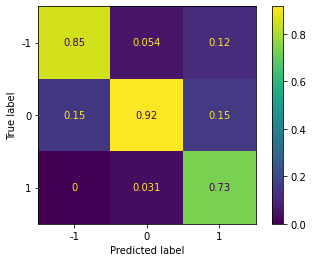

In [165]:
# initial confusion matrix
plot_confusion_matrix(mod2, X_test, y_test, normalize = 'pred');

In [167]:
# and classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, mod2.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.85      0.83      0.84       499
           0       0.92      0.90      0.91      1094
           1       0.73      0.85      0.78       217

    accuracy                           0.87      1810
   macro avg       0.83      0.86      0.84      1810
weighted avg       0.88      0.87      0.87      1810

